<h1>Car_Damage_Prediction</h1>

In [1]:
# Checking current working directory
import os
os.getcwd()

'C:\\Users\\mohdb'

In [2]:
# Change to desired location
os.chdir(r"C:\Users\mohdb\code\Damage_Prediction")

In [3]:
# Import required libraries

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

## Import Datasets

In [6]:
# Set the dataset path (adjust if needed)
dataset_path = r"C:\Users\mohdb\code\Damage_Prediction\dataset"

dataset = datasets.ImageFolder(root = dataset_path, transform=image_transforms)
print(len(dataset))

2300


In [7]:
class_names = dataset.classes

In [8]:
num_classes = len(dataset.classes)
num_classes

6

In [9]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset, val_dataset

(<torch.utils.data.dataset.Subset at 0x1c60293dbe0>,
 <torch.utils.data.dataset.Subset at 0x1c6755bd1d0>)

In [11]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [12]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

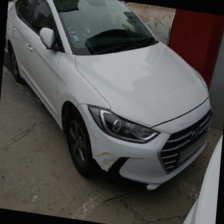

In [14]:
from torchvision import transforms as T
from PIL import Image
from IPython.display import display
import torch, numpy as np

norm = next(t for t in dataset.transform.transforms if isinstance(t, T.Normalize))
mean, std = torch.tensor(norm.mean), torch.tensor(norm.std)

x = images[1].detach().cpu()
x = x * std.view(3,1,1) + mean.view(3,1,1)
img = (x.clamp(0,1).permute(1,2,0).numpy() * 255).astype(np.uint8)
display(Image.fromarray(img))

# Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.network(x)
        return x

In [16]:
# model, loss_function, and optimizer
model = CarClassifierCNN(num_classes= num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [17]:
# defining the function to train the model
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate (train_loader):
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradient
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss:{loss.item():0.2f}")

            running_loss += loss.item()*images.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch : [{epoch+1}/{epochs}], AVG Loss: {epoch_loss:.4f}")                                              

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"***** Validation Accuracy: {100 * correct / total:.2f}%*****")


    end = time.time()
    print(f"Execution time : {end - start} seconds")
    return all_labels, all_predictions


In [18]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 3)

Batch: 10, Epoch: 1, Loss:1.76
Batch: 20, Epoch: 1, Loss:1.77
Batch: 30, Epoch: 1, Loss:1.69
Batch: 40, Epoch: 1, Loss:1.70
Batch: 50, Epoch: 1, Loss:1.49
Epoch : [1/3], AVG Loss: 1.9018
***** Validation Accuracy: 39.30%*****
Batch: 10, Epoch: 2, Loss:1.48
Batch: 20, Epoch: 2, Loss:1.46
Batch: 30, Epoch: 2, Loss:1.23
Batch: 40, Epoch: 2, Loss:1.26
Batch: 50, Epoch: 2, Loss:1.24
Epoch : [2/3], AVG Loss: 1.2859
***** Validation Accuracy: 44.00%*****
Batch: 10, Epoch: 3, Loss:1.41
Batch: 20, Epoch: 3, Loss:1.03
Batch: 30, Epoch: 3, Loss:0.91
Batch: 40, Epoch: 3, Loss:1.08
Batch: 50, Epoch: 3, Loss:0.95
Epoch : [3/3], AVG Loss: 1.1002
***** Validation Accuracy: 51.30%*****
Execution time : 756.2489855289459 seconds


## Model 2: CNN With Regularization

In [19]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.network(x)
        return x

In [20]:
# model, loss_function, and optimizer
model = CarClassifierCNNWithRegularization(num_classes= num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)

In [21]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 5)

Batch: 10, Epoch: 1, Loss:13.81
Batch: 20, Epoch: 1, Loss:5.65
Batch: 30, Epoch: 1, Loss:1.51
Batch: 40, Epoch: 1, Loss:1.61
Batch: 50, Epoch: 1, Loss:1.37
Epoch : [1/5], AVG Loss: 8.2299
***** Validation Accuracy: 46.26%*****
Batch: 10, Epoch: 2, Loss:1.22
Batch: 20, Epoch: 2, Loss:1.13
Batch: 30, Epoch: 2, Loss:1.08
Batch: 40, Epoch: 2, Loss:1.22
Batch: 50, Epoch: 2, Loss:1.33
Epoch : [2/5], AVG Loss: 1.3095
***** Validation Accuracy: 53.39%*****
Batch: 10, Epoch: 3, Loss:1.30
Batch: 20, Epoch: 3, Loss:1.41
Batch: 30, Epoch: 3, Loss:1.43
Batch: 40, Epoch: 3, Loss:1.24
Batch: 50, Epoch: 3, Loss:1.10
Epoch : [3/5], AVG Loss: 1.2333
***** Validation Accuracy: 50.96%*****
Batch: 10, Epoch: 4, Loss:1.13
Batch: 20, Epoch: 4, Loss:1.00
Batch: 30, Epoch: 4, Loss:1.02
Batch: 40, Epoch: 4, Loss:1.41
Batch: 50, Epoch: 4, Loss:1.20
Epoch : [4/5], AVG Loss: 1.1477
***** Validation Accuracy: 52.70%*****
Batch: 10, Epoch: 5, Loss:1.16
Batch: 20, Epoch: 5, Loss:1.18
Batch: 30, Epoch: 5, Loss:1.23
Ba

## Model 3: Transfer Learning Efficient Net

In [22]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights = 'DEFAULT')

         # freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
# model, loss_function, and optimizer
model = CarClassifierEfficientNet(num_classes= num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\mohdb/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:02<00:00, 10.2MB/s]


In [24]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 5)

Batch: 10, Epoch: 1, Loss:1.76
Batch: 20, Epoch: 1, Loss:1.56
Batch: 30, Epoch: 1, Loss:1.40
Batch: 40, Epoch: 1, Loss:1.32
Batch: 50, Epoch: 1, Loss:1.18
Epoch : [1/5], AVG Loss: 1.5042
***** Validation Accuracy: 57.39%*****
Batch: 10, Epoch: 2, Loss:1.32
Batch: 20, Epoch: 2, Loss:1.17
Batch: 30, Epoch: 2, Loss:1.18
Batch: 40, Epoch: 2, Loss:1.00
Batch: 50, Epoch: 2, Loss:1.11
Epoch : [2/5], AVG Loss: 1.1527
***** Validation Accuracy: 60.87%*****
Batch: 10, Epoch: 3, Loss:1.01
Batch: 20, Epoch: 3, Loss:0.91
Batch: 30, Epoch: 3, Loss:1.01
Batch: 40, Epoch: 3, Loss:0.91
Batch: 50, Epoch: 3, Loss:1.16
Epoch : [3/5], AVG Loss: 1.0184
***** Validation Accuracy: 60.35%*****
Batch: 10, Epoch: 4, Loss:0.93
Batch: 20, Epoch: 4, Loss:0.89
Batch: 30, Epoch: 4, Loss:1.26
Batch: 40, Epoch: 4, Loss:0.82
Batch: 50, Epoch: 4, Loss:0.91
Epoch : [4/5], AVG Loss: 0.9613
***** Validation Accuracy: 63.30%*****
Batch: 10, Epoch: 5, Loss:0.88
Batch: 20, Epoch: 5, Loss:0.93
Batch: 30, Epoch: 5, Loss:0.80
Bat

## Model 4: Transfer Learning using ResNet

In [25]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate = 0.5):
        super().__init__()
        self.model = models.resnet50(weights = 'DEFAULT')

        # freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layer
        for param in self.model.layer4.parameters():
            param.requires_grad = True


        # Replace the final fc layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
# model, loss_function, and optimizer
model = CarClassifierResNet(num_classes= num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\mohdb/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.8MB/s]


In [27]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 5)

Batch: 10, Epoch: 1, Loss:1.23
Batch: 20, Epoch: 1, Loss:0.83
Batch: 30, Epoch: 1, Loss:0.78
Batch: 40, Epoch: 1, Loss:0.73
Batch: 50, Epoch: 1, Loss:0.52
Epoch : [1/5], AVG Loss: 0.8800
***** Validation Accuracy: 70.61%*****
Batch: 10, Epoch: 2, Loss:0.16
Batch: 20, Epoch: 2, Loss:0.35
Batch: 30, Epoch: 2, Loss:0.60
Batch: 40, Epoch: 2, Loss:0.69
Batch: 50, Epoch: 2, Loss:0.59
Epoch : [2/5], AVG Loss: 0.4834
***** Validation Accuracy: 69.91%*****
Batch: 10, Epoch: 3, Loss:0.53
Batch: 20, Epoch: 3, Loss:0.35
Batch: 30, Epoch: 3, Loss:0.38
Batch: 40, Epoch: 3, Loss:0.36
Batch: 50, Epoch: 3, Loss:0.17
Epoch : [3/5], AVG Loss: 0.3512
***** Validation Accuracy: 76.87%*****
Batch: 10, Epoch: 4, Loss:0.15
Batch: 20, Epoch: 4, Loss:0.42
Batch: 30, Epoch: 4, Loss:0.27
Batch: 40, Epoch: 4, Loss:0.18
Batch: 50, Epoch: 4, Loss:0.29
Epoch : [4/5], AVG Loss: 0.2131
***** Validation Accuracy: 76.70%*****
Batch: 10, Epoch: 5, Loss:0.08
Batch: 20, Epoch: 5, Loss:0.09
Batch: 30, Epoch: 5, Loss:0.15
Bat

#### After running hyperparameter tunning in other notebook, it is found lr = 0.005 and gropout = 0.2 as the best parameters 

So, now lets train the CarClassifierResNet model once again on the best parameters

In [28]:
# model, loss_function, and optimizer
model = CarClassifierResNet(num_classes= num_classes, dropout_rate = 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

In [29]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 5)

Batch: 10, Epoch: 1, Loss:1.13
Batch: 20, Epoch: 1, Loss:0.99
Batch: 30, Epoch: 1, Loss:0.99
Batch: 40, Epoch: 1, Loss:0.99
Batch: 50, Epoch: 1, Loss:0.64
Epoch : [1/5], AVG Loss: 0.9144
***** Validation Accuracy: 67.83%*****
Batch: 10, Epoch: 2, Loss:0.66
Batch: 20, Epoch: 2, Loss:0.54
Batch: 30, Epoch: 2, Loss:0.58
Batch: 40, Epoch: 2, Loss:0.72
Batch: 50, Epoch: 2, Loss:0.64
Epoch : [2/5], AVG Loss: 0.5757
***** Validation Accuracy: 73.22%*****
Batch: 10, Epoch: 3, Loss:0.36
Batch: 20, Epoch: 3, Loss:0.41
Batch: 30, Epoch: 3, Loss:0.39
Batch: 40, Epoch: 3, Loss:0.48
Batch: 50, Epoch: 3, Loss:0.46
Epoch : [3/5], AVG Loss: 0.4352
***** Validation Accuracy: 70.26%*****
Batch: 10, Epoch: 4, Loss:0.36
Batch: 20, Epoch: 4, Loss:0.51
Batch: 30, Epoch: 4, Loss:0.17
Batch: 40, Epoch: 4, Loss:0.55
Batch: 50, Epoch: 4, Loss:0.31
Epoch : [4/5], AVG Loss: 0.3158
***** Validation Accuracy: 76.00%*****
Batch: 10, Epoch: 5, Loss:0.50
Batch: 20, Epoch: 5, Loss:0.39
Batch: 30, Epoch: 5, Loss:0.23
Bat

## Model Evaluation using Confusion Metrix and Classification Report

In [30]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       131
           1       0.64      0.76      0.70        91
           2       0.81      0.91      0.85       128
           3       0.79      0.75      0.77        73
           4       0.62      0.78      0.69        77
           5       0.89      0.67      0.76        75

    accuracy                           0.77       575
   macro avg       0.78      0.76      0.76       575
weighted avg       0.79      0.77      0.77       575



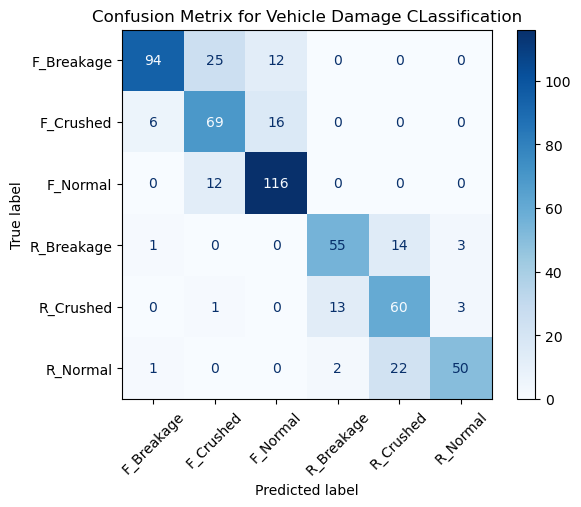

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mtrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrix, display_labels = class_names)
disp.plot(cmap = plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Metrix for Vehicle Damage CLassification")
plt.show()

In [32]:
torch.save(model.state_dict(), "saved_model.pth")